# LSTM

# 🌫️ Air Pollution Forecasting using PM2.5 Data

## 📖 Overview

This project focuses on forecasting air pollution levels, specifically PM2.5 concentration, using historical weather and pollution data collected hourly over five years at the U.S. Embassy in Beijing, China.

We frame a time series forecasting problem:

> **Given weather conditions and pollution levels in the past, predict the PM2.5 concentration for the next hour.**

---

## 📊 Dataset Description

The dataset includes the following features:

* `No`: Row index
* `year`, `month`, `day`, `hour`: Timestamp components
* `pm2.5`: PM2.5 concentration (target variable)
* `DEWP`: Dew point
* `TEMP`: Temperature
* `PRES`: Atmospheric pressure
* `cbwd`: Combined wind direction
* `Iws`: Cumulative wind speed
* `Is`: Cumulative hours of snow
* `Ir`: Cumulative hours of rain


Place the file in your working directory and rename it to `raw.csv`.

---

## 🔮 Possible Forecasting Tasks

Apart from hourly PM2.5 prediction, you can explore:

* Daily or weekly PM2.5 average prediction
* Forecasting weather features like temperature or dew point
* Predicting extreme pollution events (classification)
* Multivariate time series forecasting with weather & pollution variables

---


In [21]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [7]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np # <-- Keep this import

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)

# --- CRITICAL DEBUGGING STEPS ---

print("--- Initial DataFrame Info ---")
dataset.info()
print("\n--- Initial DataFrame Head ---")
print(dataset.head())

# Find all columns that are not numeric (dtype 'object' or other non-numeric)
non_numeric_cols = dataset.select_dtypes(include=['object']).columns
print(f"\n--- Non-numeric columns detected: {list(non_numeric_cols)} ---")

# If 'cbwd' is a column name and it's non-numeric, we can directly select it
if 'cbwd' in non_numeric_cols:
    print(f"Applying LabelEncoder to 'cbwd' column (index {dataset.columns.get_loc('cbwd')})")
    # Convert 'cbwd' column in the DataFrame first, then to values
    dataset['cbwd'] = encoder.fit_transform(dataset['cbwd'])
    # Update non_numeric_cols as 'cbwd' is now handled
    non_numeric_cols = dataset.select_dtypes(include=['object']).columns
elif len(non_numeric_cols) > 0:
    # If 'cbwd' wasn't found by name, iterate through all detected non-numeric columns
    # and apply LabelEncoder to them.
    print(f"Applying LabelEncoder to all detected non-numeric columns.")
    encoder = LabelEncoder() # Re-initialize if you want separate encoders for each column, though typically one for all is fine for this case
    for col_name in non_numeric_cols:
        print(f"Encoding column: '{col_name}' (original column index: {dataset.columns.get_loc(col_name)})")
        print(f"Unique values in '{col_name}' before encoding: {dataset[col_name].unique()}")
        dataset[col_name] = encoder.fit_transform(dataset[col_name])
else:
    print("No 'object' dtype columns found. Proceeding assuming all columns are numeric or have been handled.")

# IMPORTANT: Convert the DataFrame to values *after* all encoding
values = dataset.values

# After potential encoding, check the types of the values array again (this will be of object type if any string remains)
# This will confirm if the strings are gone from the numpy array level
print("\n--- Type of values array elements after encoding attempt ---")
# Pick a few elements to inspect, especially from the column that used to be strings
print("Example element types from values array:")
if values.shape[0] > 0 and values.shape[1] > 0:
    for i in range(min(5, values.shape[0])): # Check first 5 rows
        for j in range(values.shape[1]): # Check all columns
            # Check if the element is a string before attempting conversion
            if isinstance(values[i, j], str):
                print(f"  String found at values[{i}, {j}]: '{values[i, j]}'")
else:
    print("Values array is empty or malformed.")

# Now, ensure all data is float *after* encoding all categorical columns
# This line should now succeed if all strings have been converted to numbers
print("\nAttempting to convert entire array to float32...")
values = values.astype('float32')
print("Successfully converted values to float32.")


# 4. Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 5. Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# 6. Drop columns we don't want to predict
# Based on your indices [9,10,11,12,13,14,15], these would correspond to 'var2(t)' through 'var8(t)' if there are 8 original features.
# Make sure these indices are correct for your specific prediction task.
# This assumes you have 8 original features (var1 to var8).
# var1(t) is at index 8. So var2(t) is 9, etc.
# If you only want to predict var1(t) (pollution at t), then dropping var2(t) to var8(t) makes sense.
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("\n--- Reframed DataFrame Head (final output) ---")
print(reframed.head())

--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 1 to 43824
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   pm2.5   41757 non-null  float64
 5   DEWP    43824 non-null  int64  
 6   TEMP    43824 non-null  float64
 7   PRES    43824 non-null  float64
 8   cbwd    43824 non-null  object 
 9   Iws     43824 non-null  float64
 10  Is      43824 non-null  int64  
 11  Ir      43824 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 4.3+ MB

--- Initial DataFrame Head ---
    year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
No                                                                       
1   2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2   2010      1    1     1    N

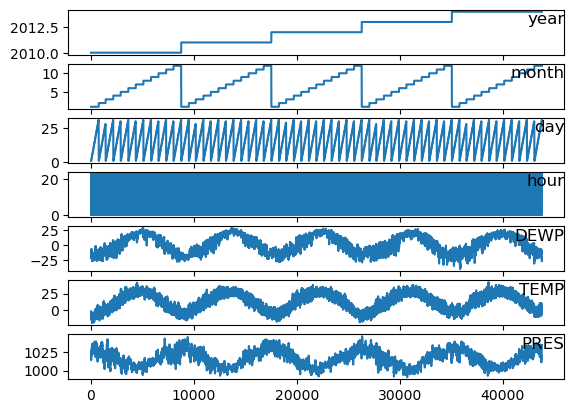

In [8]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()


## 🤖 Multivariate LSTM Forecast Model

### 🧹 LSTM Data Preparation

To train an LSTM model, the pollution dataset must first be prepared by:

* Framing it as a supervised learning problem
* Normalizing input variables

We predict the pollution at the current hour (`t`) given pollution and weather conditions at the previous hour (`t-1`).

### 📌 Alternate Formulations

Some variations you can try include:

* Predict next-hour pollution using past 24 hours of data
* Predict next-hour pollution with current and expected weather conditions

### 🛠️ Data Transformation

The dataset is processed with the `series_to_supervised()` utility, as described in:
[How to Convert a Time Series to a Supervised Learning Problem in Python](#)

Steps:

1. Load the `pollution.csv` dataset
2. Label encode the `cbwd` (wind direction) feature — optionally, you can one-hot encode this
3. Normalize all features
4. Frame the dataset as a supervised learning problem
5. Drop weather variables for time `t` (target)

The full code implementation follows this pipeline and ensures the data is in a format suitable for feeding into an LSTM network.


In [11]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np # Make sure numpy is imported

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)

# --- START OF MODIFIED AND DEBUGGED SECTION ---

print("--- Initial DataFrame Info ---")
dataset.info()
print("\n--- Initial DataFrame Head ---")
print(dataset.head())

# Identify columns with 'object' dtype (which usually means strings)
string_columns = dataset.select_dtypes(include=['object']).columns

if len(string_columns) == 0:
    print("\nNo 'object' (string) columns found. Proceeding with conversion.")
else:
    print(f"\nFound string columns: {list(string_columns)}")
    # Apply LabelEncoder to each identified string column
    for col in string_columns:
        print(f"Encoding column '{col}'...")
        encoder = LabelEncoder() # Create a new encoder for each column if you want separate mappings, or reuse one if mappings don't need to be unique per column type. For simplicity, reusing is fine here.
        dataset[col] = encoder.fit_transform(dataset[col])
        print(f"Unique values in '{col}' after encoding: {dataset[col].unique()}")

# Now, convert the DataFrame to a NumPy array after all string columns are handled
values = dataset.values

# Double-check for any remaining non-numeric types in the numpy array itself
# This step is crucial if the above detection missed anything or if there's mixed data in a column
for col_idx in range(values.shape[1]):
    # Check a sample of values in the column
    sample_values = values[:5, col_idx] # Check first 5 rows
    for val in sample_values:
        if isinstance(val, str):
            print(f"ERROR: String '{val}' found at column index {col_idx} even after encoding attempt!")
            # If this prints, it means our string_columns detection or encoding was incomplete.
            # This is where you might need to manually inspect the pollution.csv file.
            break # No need to check more values in this column if a string is found

# Ensure all data is float. This line should now succeed if all strings are gone.
print("\nAttempting to convert entire array to float32...")
try:
    values = values.astype('float32')
    print("Successfully converted values to float32.")
except ValueError as e:
    print(f"FINAL ERROR: Could not convert to float32. Error: {e}")
    print("This means there are still non-numeric values in your data.")
    print("Please review the 'pollution.csv' file manually, especially any columns that were not detected as 'object' dtype but contain strings, or mixed types.")
    raise # Re-raise the error so you can see the traceback
# --- END OF MODIFIED AND DEBUGGED SECTION ---

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# Assuming 'var1(t)' (pollution at t) is the target, and others are dropped.
# In a typical pollution.csv, there are 8 features.
# So, var1(t) is at index 8, var2(t) at 9, and so on.
# If you want to predict only var1(t), you'd drop var2(t) through var8(t).
# These are the columns from index 9 up to (8 + 8 - 1 = 15).
# So, reframed.columns[[9,10,11,12,13,14,15]] correctly targets these.
# If your dataset has a different number of features, these indices might need adjustment.
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("\n--- Reframed DataFrame Head ---")
print(reframed.head())

--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 1 to 43824
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   pm2.5   41757 non-null  float64
 5   DEWP    43824 non-null  int64  
 6   TEMP    43824 non-null  float64
 7   PRES    43824 non-null  float64
 8   cbwd    43824 non-null  object 
 9   Iws     43824 non-null  float64
 10  Is      43824 non-null  int64  
 11  Ir      43824 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 4.3+ MB

--- Initial DataFrame Head ---
    year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
No                                                                       
1   2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2   2010      1    1     1    N

## Define and Fit Model

In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [12]:
...
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 16) (8760,) (32783, 1, 16) (32783,)


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

D:\ju\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          13,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,451 (52.54 KB)

 Trainable params: 13,451 (52.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
122/122 - 7s - 54ms/step - loss: 0.0158 - val_loss: 0.0249
Epoch 2/50
122/122 - 1s - 10ms/step - loss: 0.0120 - val_loss: 0.0199
Epoch 3/50
122/122 - 1s - 10ms/step - loss: 0.0105 - val_loss: 0.0250
Epoch 4/50
122/122 - 2s - 14ms/step - loss: 0.0117 - val_loss: 0.0193
Epoch 5/50
122/122 - 2s - 13ms/step - loss: 0.0123 - val_loss: 0.0151
Epoch 6/50
122/122 - 1s - 12ms/step - loss: 0.0119 - val_loss: 0.0136
Epoch 7/50
122/122 - 1s - 11ms/step - loss: 0.0098 - val_loss: 0.0125
Epoch 8/50
122/122 - 1s - 12ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 9/50
122/122 - 2s - 14ms/step - loss: 0.0103 - val_loss: 0.0137
Epoch 10/50
122/122 - 1s - 10ms/step - loss: 0.0093 - val_loss: 0.0102
Epoch 11/50
122/122 - 1s - 12ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 12/50
122/122 - 1s - 10ms/step - loss: 0.0102 - val_loss: 0.0130
Epoch 13/50
122/122 - 2s - 20ms/step - loss: 0.0109 - val_loss: 0.0063
Epoch 14/50
122/122 - 1s - 10ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 15/5

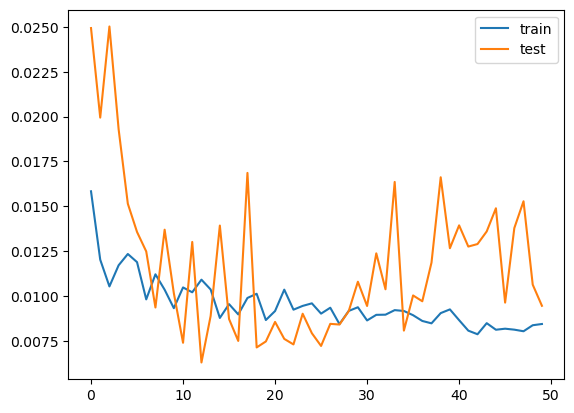

In [14]:
# Import necessary components for your LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as pyplot # Assuming you use pyplot for plotting, if not, adjust as needed

# ... (your data preparation code, including train_X, train_y, test_X, test_y definitions) ...

# Assuming train_X, train_y, test_X, test_y are already defined from your data preparation steps.
# For demonstration purposes, let's create dummy shapes if these aren't available yet:
# For example, if train_X has shape (samples, timesteps, features)
# train_X = np.random.rand(100, 1, 8) # Example: 100 samples, 1 timestep, 8 features
# train_y = np.random.rand(100, 1)
# test_X = np.random.rand(20, 1, 8)
# test_y = np.random.rand(20, 1)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Print model summary to verify structure (optional, but good for debugging)
print(model.summary())

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test') # It should be 'val_loss', not 'test_loss' usually
pyplot.legend()
pyplot.show()

Evaluate Model
After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

Found string columns: ['cbwd']. Encoding them...
Values array shape after type conversion: (43824, 12)
Scaled values shape: (43824, 12)
Reframed shape: (41543, 24)
Reframed Head (after series_to_supervised):
    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
25        0.0        0.0   0.033333   0.000000   0.129779   0.352941   
26        0.0        0.0   0.033333   0.043478   0.148893   0.367647   
27        0.0        0.0   0.033333   0.086957   0.159960   0.426471   
28        0.0        0.0   0.033333   0.130435   0.182093   0.485294   
29        0.0        0.0   0.033333   0.173913   0.138833   0.485294   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var3(t)   var4(t)  \
25   0.245902   0.527273   0.666667    0.002290  ...  0.033333  0.043478   
26   0.245902   0.527273   0.666667    0.003811  ...  0.033333  0.086957   
27   0.229508   0.545454   0.666667    0.005332  ...  0.033333  0.130435   
28   0.229508   0.563637   0.666667    0.008391  ...  0

D:\ju\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Model ---
Epoch 1/50
122/122 - 3s - 28ms/step - loss: 0.0231 - val_loss: 0.5575
Epoch 2/50
122/122 - 1s - 11ms/step - loss: 0.0298 - val_loss: 0.4917
Epoch 3/50
122/122 - 1s - 8ms/step - loss: 0.0295 - val_loss: 0.4482
Epoch 4/50
122/122 - 1s - 9ms/step - loss: 0.0283 - val_loss: 0.4420
Epoch 5/50
122/122 - 1s - 8ms/step - loss: 0.0212 - val_loss: 0.3766
Epoch 6/50
122/122 - 1s - 8ms/step - loss: 0.0239 - val_loss: 0.3507
Epoch 7/50
122/122 - 1s - 9ms/step - loss: 0.0214 - val_loss: 0.3227
Epoch 8/50
122/122 - 1s - 9ms/step - loss: 0.0165 - val_loss: 0.2696
Epoch 9/50
122/122 - 1s - 10ms/step - loss: 0.0126 - val_loss: 0.1785
Epoch 10/50
122/122 - 1s - 11ms/step - loss: 0.0172 - val_loss: 0.1266
Epoch 11/50
122/122 - 1s - 11ms/step - loss: 0.0144 - val_loss: 0.0698
Epoch 12/50
122/122 - 1s - 11ms/step - loss: 0.0076 - val_loss: 0.0295
Epoch 13/50
122/122 - 2s - 13ms/step - loss: 0.0057 - val_loss: 0.0288
Epoch 14/50
122/122 - 1s - 10ms/step - loss: 0.0060 - val_loss: 0.02

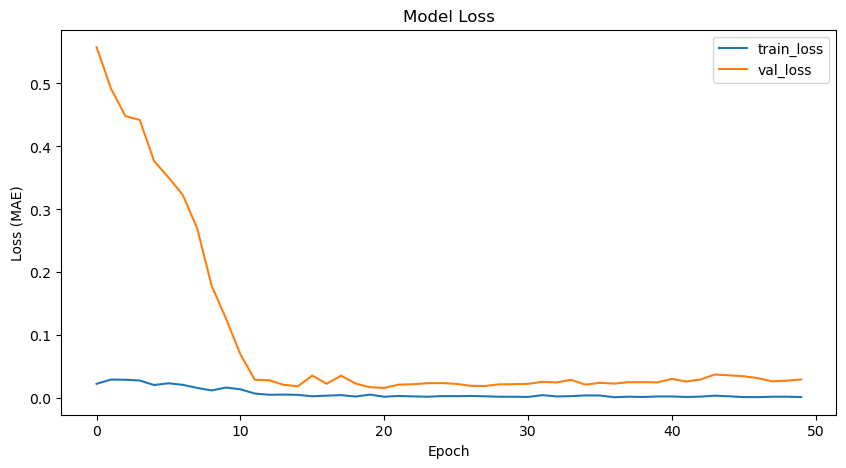


--- Making Predictions ---
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
yhat (predicted) shape: (32783, 1)
test_X_for_inverse shape: (32783, 12)
inv_yhat (inverse transformed prediction) shape: (32783,)
inv_y (inverse transformed actual) shape: (32783,)
Test RMSE: 0.158


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt # For plotting history if you want
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Data Preparation Function (from your original code) ---
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data) # Use pd.DataFrame here explicitly
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1) # Use pd.concat explicitly
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# --- Load and Prepare Dataset ---
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)

# Identify and encode all 'object' (string) columns
string_columns = dataset.select_dtypes(include=['object']).columns
if len(string_columns) > 0:
    print(f"Found string columns: {list(string_columns)}. Encoding them...")
    encoder = LabelEncoder()
    for col in string_columns:
        dataset[col] = encoder.fit_transform(dataset[col])
else:
    print("No 'object' (string) columns found in the dataset.")

# Ensure all data is float
values = dataset.values.astype('float32')
print(f"Values array shape after type conversion: {values.shape}")


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(f"Scaled values shape: {scaled.shape}")

# frame as supervised learning
# n_hours is the number of lag observations for input sequence (X)
# n_features is the number of features (columns) in the original dataset
n_hours = 1 # Using 1 hour (t-1) as input, predicting t
n_features = scaled.shape[1] # Number of original features (e.g., 8 for pollution dataset)

reframed = series_to_supervised(scaled, n_hours, 1)
print(f"Reframed shape: {reframed.shape}")
print("Reframed Head (after series_to_supervised):")
print(reframed.head())

# Drop columns we don't want to predict
# Assuming we want to predict 'pollution' (var1(t)) and drop all other 't' values
# The original dataset typically has 8 features.
# If n_hours=1, the columns will be:
# var1(t-1)...var8(t-1) | var1(t)...var8(t)
# We want to keep var1(t), so we drop var2(t) to var8(t).
# The indices will be: var1(t-1)=0, ..., var8(t-1)=7, var1(t)=8, var2(t)=9, ..., var8(t)=15.
# So, dropping columns 9 to 15 is correct if n_features = 8 and n_hours = 1.
columns_to_drop = [reframed.columns[n_features * n_hours + i] for i in range(1, n_features)]
reframed.drop(columns_to_drop, axis=1, inplace=True)
print(f"\nReframed shape after dropping target columns: {reframed.shape}")
print("Reframed Head (final, ready for split):")
print(reframed.head())

# Split into train and test sets
values_reframed = reframed.values
n_train_hours = 365 * 24 # Example: one year of hourly data for training
train = values_reframed[:n_train_hours, :]
test = values_reframed[n_train_hours:, :]

# Split into input (X) and outputs (y)
# X will be the lagged features (t-n_hours to t-1)
# y will be the target feature (t)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features] for LSTM
# For this setup:
# samples = number of rows
# timesteps = n_hours (how many previous steps are used as input for one prediction)
# features = number of input features (n_features * n_hours)
# NO! This is the most common mistake for this specific structure.
# Features here is the number of features in EACH timestep.
# If n_hours = 1, and you have 8 original features, then the input features for LSTM is 8.
# So, train_X.shape[1] is the number of features here (e.g., 8)
# and n_hours is the number of timesteps.
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(f"\nFinal train_X shape for LSTM: {train_X.shape}")
print(f"Final train_y shape for LSTM: {train_y.shape}")
print(f"Final test_X shape for LSTM: {test_X.shape}")
print(f"Final test_y shape for LSTM: {test_y.shape}")


# --- Build and Train LSTM Model ---
# design network
model = Sequential()
# Input shape for LSTM is (timesteps, features)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1)) # Output is a single prediction (e.g., pollution at t)
model.compile(loss='mae', optimizer='adam')

# Print model summary to verify structure
print("\n--- Model Summary ---")
model.summary()

# fit network
print("\n--- Training Model ---")
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history (assuming matplotlib.pyplot as plt is imported)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

# --- Make Predictions and Inverse Transform ---
print("\n--- Making Predictions ---")
# make a prediction
# test_X is already in the correct 3D shape (samples, timesteps, features)
yhat = model.predict(test_X)
print(f"yhat (predicted) shape: {yhat.shape}")

# Reshape test_X from (samples, timesteps, features) to (samples, features) for inverse scaling.
# This assumes n_hours = 1, so timesteps dimension is 1.
# If n_hours > 1, you'd need to decide which timestep's features to use for inverse scaling.
# Common practice is to use the last timestep's features.
# For n_hours=1, test_X.shape[1] (timesteps) is 1, test_X.shape[2] (features) is n_features.
# So reshaping to (test_X.shape[0], test_X.shape[2]) is equivalent to (samples, n_features).
test_X_for_inverse = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(f"test_X_for_inverse shape: {test_X_for_inverse.shape}")


# invert scaling for forecast (yhat)
# yhat is (samples, 1) - it's the predicted pollution (var1).
# We need to concatenate it with the other features (var2 to var8) from test_X to inverse_transform.
# test_X_for_inverse[:, 1:] takes columns from index 1 onwards (var2 to var8)
# This assumes your target variable (pollution) was the first column (index 0) in your original `values` array.
inv_yhat = np.concatenate((yhat, test_X_for_inverse[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0] # Get back the pollution column
print(f"inv_yhat (inverse transformed prediction) shape: {inv_yhat.shape}")

# invert scaling for actual (test_y)
# test_y is (samples,) - reshape to (samples, 1) for concatenation
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshaped, test_X_for_inverse[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0] # Get back the actual pollution column
print(f"inv_y (inverse transformed actual) shape: {inv_y.shape}")

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(f'Test RMSE: {rmse:.3f}')